In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [2]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

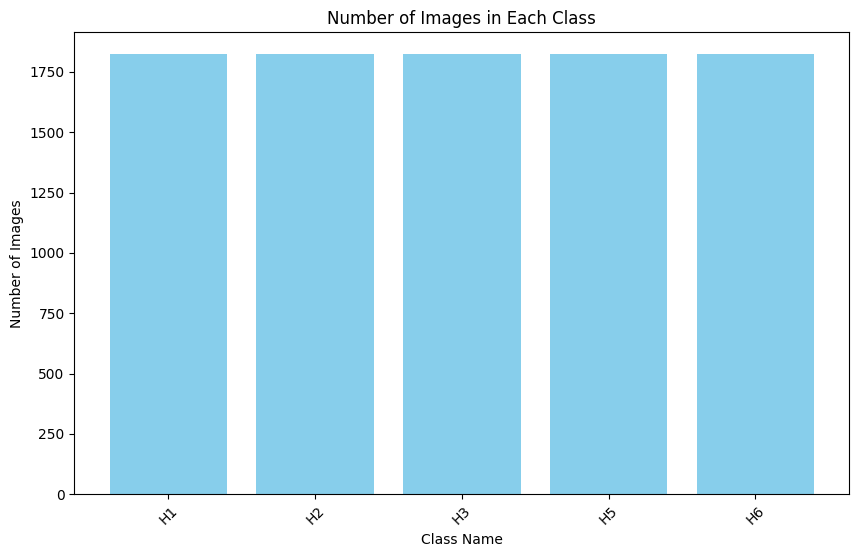

In [3]:
import matplotlib.pyplot as plt

input_folder = "defungi2"

class_names = os.listdir(input_folder)

num_images_per_class = []
for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    num_images = len(os.listdir(class_folder))
    num_images_per_class.append(num_images)

plt.figure(figsize=(10, 6))
plt.bar(class_names, num_images_per_class, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_folder = "defungi"
output_folder = "output"

class_names = os.listdir(input_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    output_train_folder = os.path.join(output_folder, "train", class_name)
    output_test_folder = os.path.join(output_folder, "test", class_name)
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    images = os.listdir(class_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    for image in train_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_train_folder, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_test_folder, image)
        shutil.copy(src, dest)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'output/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    seed=42
)

class_names = train_dataset.class_names
class_names


Found 7290 files belonging to 5 classes.


['H1', 'H2', 'H3', 'H5', 'H6']

In [5]:
image_size = 256

data_generator_with_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        'output/train',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

validation_generator = data_generator_no_aug.flow_from_directory(
        'output/test',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf

# Load VGG16 model without the fully connected layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in vgg_base.layers:
    layer.trainable = False

# Adding custom fully connected layers
x = GlobalAveragePooling2D()(vgg_base.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # Assuming 5 classes for classification

# Create the model
model = Model(inputs=vgg_base.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0010),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=8)

In [10]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/200
228/228 [==============================] - 97s 355ms/step - loss: 1.2333 - accuracy: 0.5104 - val_loss: 0.9338 - val_accuracy: 0.6206
Epoch 2/200
228/228 [==============================] - 75s 328ms/step - loss: 0.9905 - accuracy: 0.6019 - val_loss: 0.8510 - val_accuracy: 0.6760
Epoch 3/200
228/228 [==============================] - 75s 331ms/step - loss: 0.8959 - accuracy: 0.6410 - val_loss: 0.7457 - val_accuracy: 0.7023
Epoch 4/200
228/228 [==============================] - 77s 336ms/step - loss: 0.8327 - accuracy: 0.6605 - val_loss: 0.7126 - val_accuracy: 0.7155
Epoch 5/200
228/228 [==============================] - 77s 340ms/step - loss: 0.7899 - accuracy: 0.6860 - val_loss: 0.7097 - val_accuracy: 0.7133
Epoch 6/200
228/228 [==============================] - 78s 343ms/step - loss: 0.7624 - accuracy: 0.6912 - val_loss: 0.7205 - val_accuracy: 0.7270
Epoch 7/200
228/228 [==============================] - 78s 343ms/step - loss: 0.7431 - accuracy: 0.7004 - val_loss: 0.6810 -

In [11]:
hist = model.history

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
hist = hist.history

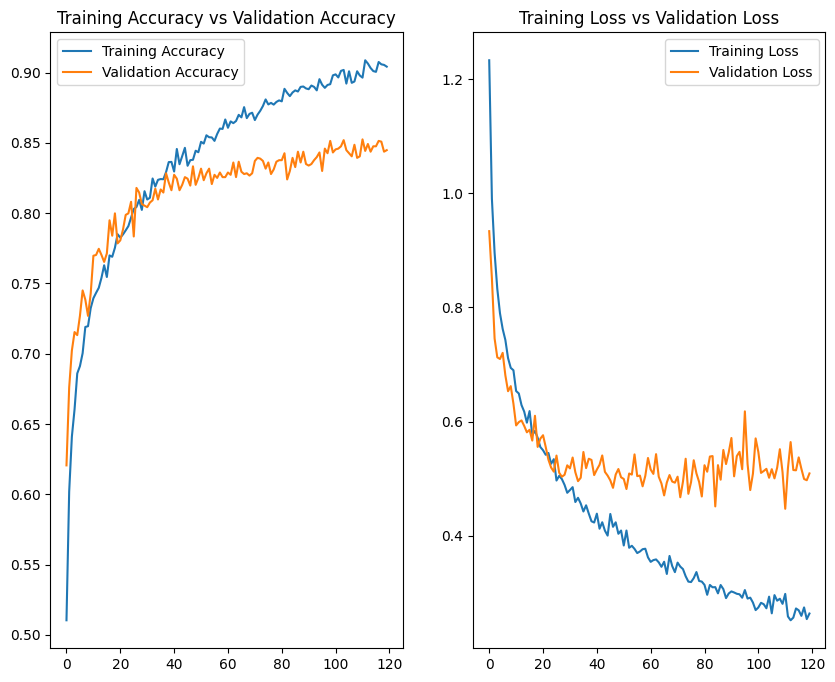

In [16]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

loss=hist['loss']
val_loss=hist['val_loss']

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(range(120),acc,label='Training Accuracy')
plt.plot(range(120),val_acc,label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(120),loss,label='Training Loss')
plt.plot(range(120),val_loss,label='Validation Loss')
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

In [17]:
model.save("vgg3.h5")

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("models/vgg3.h5",compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

57/57 [==============================] - 30s 260ms/step - loss: 0.5091 - accuracy: 0.8448
Test Loss: 0.5091127157211304
Test Accuracy: 0.8448464870452881


In [8]:
from sklearn.metrics import classification_report

# Generate predictions for the test set
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = validation_generator.classes

# Generate class-wise classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(class_report)


57/57 [==============================] - 15s 260ms/step
Classification Report:
              precision    recall  f1-score   support

          H1       0.83      0.95      0.88       881
          H2       0.84      0.61      0.71       467
          H3       0.78      0.85      0.82       164
          H5       0.91      0.93      0.92       164
          H6       0.99      0.87      0.93       148

    accuracy                           0.84      1824
   macro avg       0.87      0.84      0.85      1824
weighted avg       0.85      0.84      0.84      1824



In [9]:
from sklearn.metrics import precision_recall_fscore_support

predicted_probabilities = model.predict(validation_generator, verbose=1)

true_labels = []
for x, y in validation_generator:
    true_labels.extend(np.argmax(y, axis=1))
    if len(true_labels) >= len(predicted_probabilities):
        break

predicted_labels = np.argmax(predicted_probabilities, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

57/57 [==============================] - 15s 262ms/step
Precision: 0.8472456954780941
Recall: 0.8448464912280702
F1-score: 0.8393752552140298


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    return img_array

def predict_images(model, image_paths, class_names):
    predictions = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path)
        pred_probs = model.predict(img_array)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class = class_names[predicted_class_index]
        predictions.append(predicted_class)
    return predictions

image_paths = ["defungi/H6/H6_2a_15.jpg","defungi/H2/H2_1a_1.jpg","defungi/H3/H3_1b_1.jpg","defungi/H5/H5_1a_1.jpg","defungi/H3/H3_2a_10.jpg"]
predicted_classes = predict_images(model, image_paths, class_names)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i+1} Predicted Class:", predicted_class)



1/1 [==============================] - 0s 17ms/step
Image 1 Predicted Class: H6
Image 2 Predicted Class: H2
Image 3 Predicted Class: H3
Image 4 Predicted Class: H5
Image 5 Predicted Class: H3
